In [1]:
!pip install requests tqdm

import os
import requests
from tqdm import tqdm

# ==== SETTINGS ====
ACCESS_KEY = "123456789"  # 🔑 Replace with your Unsplash Access Key
categories = {"hotdog": 200, "food": 500}  # target counts

def download_images(query, n_images):
    """Download images from Unsplash API search."""
    folder = os.path.join(save_dir, query)
    os.makedirs(folder, exist_ok=True)

    per_page = 30  # Unsplash API limit per page
    total_downloaded = 0
    page = 1

    print(f"\nDownloading '{query}' images...")

    while total_downloaded < n_images:
        url = f"https://api.unsplash.com/search/photos"
        params = {
            "query": query,
            "page": page,
            "per_page": per_page,
            "client_id": ACCESS_KEY,
        }

        res = requests.get(url, params=params)
        if res.status_code != 200:
            print("Error:", res.status_code, res.text)
            break

        data = res.json().get("results", [])
        if not data:
            print("No more results found.")
            break

        for img in data:
            img_url = img["urls"]["regular"]
            img_id = img["id"]
            save_path = os.path.join(folder, f"{img_id}.jpg")

            if not os.path.exists(save_path):
                img_data = requests.get(img_url).content
                with open(save_path, "wb") as f:
                    f.write(img_data)
                total_downloaded += 1

            if total_downloaded >= n_images:
                break

        print(f"Downloaded {total_downloaded}/{n_images}")
        page += 1

    print(f"✅ Finished '{query}' ({total_downloaded} images).")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
save_dir = "/content/drive/My Drive/unsplash_images"
os.makedirs(save_dir, exist_ok=True)

In [9]:
categories = {"hotdog": 200, "food": 500}  # target counts

# Run downloads
for query, n in categories.items():
    download_images(query, n)


Downloaded 30/200
Downloaded 60/200
Downloaded 89/200
Downloaded 118/200
Downloaded 148/200
Downloaded 178/200
Downloaded 200/200
✅ Finished 'hotdog' (200 images).

Downloaded 30/500
Downloaded 60/500
Downloaded 90/500
Downloaded 120/500
Downloaded 150/500
Downloaded 180/500
Downloaded 210/500
Downloaded 240/500
Downloaded 270/500
Downloaded 300/500
Downloaded 330/500
Downloaded 360/500
Downloaded 390/500
Downloaded 420/500
Downloaded 450/500
Downloaded 480/500
Downloaded 500/500
✅ Finished 'food' (500 images).


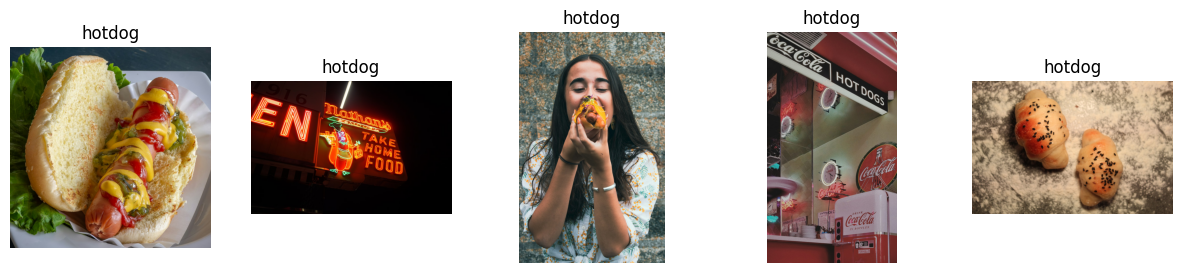

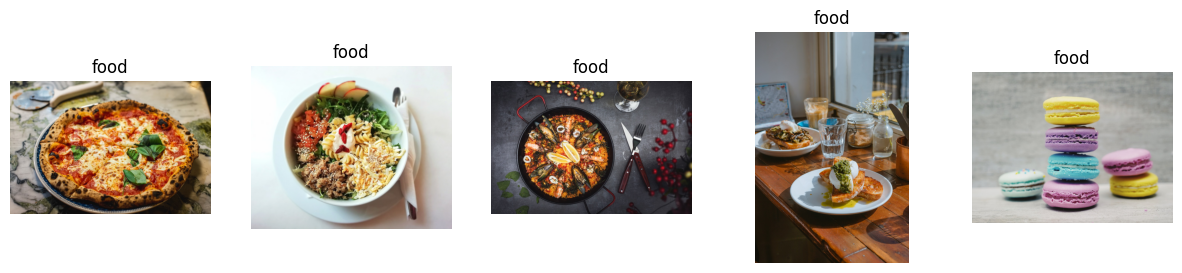

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, random

for query in ["hotdog", "food"]:
    files = random.sample(glob.glob(f"/content/drive/My Drive/unsplash_images/{query}/*.jpg"), 5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax, f in zip(axes, files):
        ax.imshow(mpimg.imread(f))
        ax.set_title(query)
        ax.axis('off')
    plt.show()

[I 2025-11-16 17:43:01,783] A new study created in memory with name: no-name-41b52580-0da5-4774-9c1d-503d85f26781


Using device: cuda
Classes: ['food', 'hotdog']


/tmp/ipython-input-1801702387.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
[I 2025-11-16 17:47:34,140] Trial 0 finished with value: 0.5092686215032018 and parameters: {'lr': 1.5874622337375336e-06, 'batch_size': 32, 'epochs': 22}. Best is trial 0 with value: 0.5092686215032018.
/tmp/ipython-input-1801702387.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
[I 2025-11-16 17:53:27,553] Trial 1 finished with value: 0.9492063492063492 and parameters: {'lr': 1.9935404824567045e-05, 'batch_size': 4, 'epochs': 27}. Best is trial 1 with value: 0.9492063492063492.
/tmp/ipyt


Best trial: {'lr': 1.9935404824567045e-05, 'batch_size': 4, 'epochs': 27}


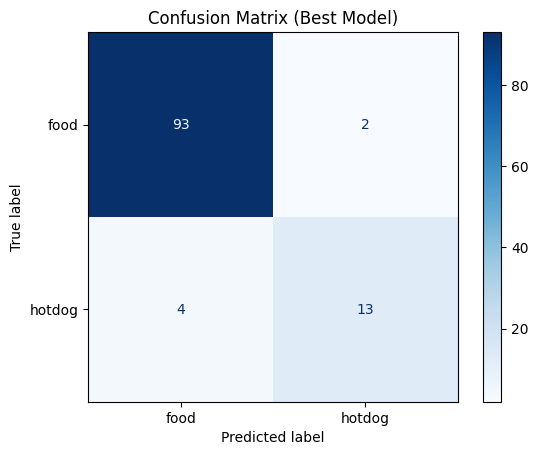

In [7]:
# === SETUP ===
!pip install torch torchvision scikit-learn optuna --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
import numpy as np
import matplotlib.pyplot as plt

# ==== GPU ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== DATA ====
data_dir = "/content/drive/My Drive/unsplash_images"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# Split into train/test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# ==== MODEL CREATION WITH PARTIAL FREEZE ====
def create_model(freeze_type="partial"):  # "partial" = freeze all except last block + fc
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    if freeze_type == "partial":
        # Freeze all layers first
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze last residual block
        for param in model.layer4.parameters():
            param.requires_grad = True
        # fc is trainable by default

    # Replace classifier
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))

    return model.to(device)

# ==== TRAIN/EVAL ====
def train_eval(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    # evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average="macro")

# ==== OPTUNA TUNING ====
def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16, 32, 64])
    epochs = trial.suggest_int("epochs", 10, 30)

    freeze_type = "partial"  # partial freeze

    train_loader, val_loader = get_dataloaders(batch_size)
    model = create_model(freeze_type)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    f1 = train_eval(model, train_loader, val_loader, criterion, optimizer, epochs)
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("\nBest trial:", study.best_trial.params)

# ==== FINAL EVALUATION ON TEST SET ====
best_params = study.best_trial.params
train_loader, test_loader = get_dataloaders(best_params["batch_size"])

best_model = create_model("partial")  # partial freeze

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, best_model.parameters()), lr=best_params["lr"])

train_eval(best_model, train_loader, test_loader, criterion, optimizer, best_params["epochs"])

# Confusion Matrix
best_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = best_model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Model)")
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, f1_score

# ==== TEST METRICS ====
test_f1 = f1_score(y_true, y_pred, average="macro")
test_acc = accuracy_score(y_true, y_pred)

print(f"\n✅ Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1-score: {test_f1:.4f}")


✅ Test Results:
Accuracy: 0.9464
Macro F1-score: 0.8906
